In [1]:
import tensorflow as tf
import numpy as np

from skimage import transform
from skimage.io import imread

import os
from random import shuffle
from tqdm import tqdm

import matplotlib.pyplot as plt


%matplotlib inline

## Get Data

In [4]:
def get_data(n=202500):

    input_dir = './img_align_celeba/'

    files = os.listdir(input_dir)
    shuffle(files)
    images = []
    images_fn = files[:n]

    for f in tqdm(images_fn):
        images.append(transform.resize(imread(input_dir + f), (32,32,3), mode='constant')) #resize the images for computational efficiency

    return images

In [5]:
images = get_data(n=1500)

100%|██████████| 1500/1500 [00:08<00:00, 181.69it/s]


## Helper Functions

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

## DCGAN Generator

In [7]:
class Generator(object):
    def __init__(self):
        self.z_dim = 100
        self.x_dim = 64*64*3
        self.name = "Generator"
    def go(self, z):
        """takes in a z random vector and returns an output image"""
        with tf.variable_scope(self.name) as scope:
            batch_size = tf.shape(z)[0]
            fc = tf.contrib.layers.fully_connected(z, 4*4*1024, activation_fn=tf.identity)
            reshape_fc = tf.reshape(fc, [1, 4, 4, 1024])
            
            conv1 = tf.contrib.layers.conv2d_transpose(
                reshape_fc, 512, [4,4], [2,2],
                weights_initializer = tf.random_normal_initializer(stddev=0.02), #st_dev from dcgan paper
                activation_fn = leaky_relu
            )
            
            conv2 = tf.contrib.layers.conv2d_transpose(
                conv1, 256, [4, 4], [2,2],
                weights_initializer = tf.random_normal_initializer(stddev=0.02),
                activation_fn = leaky_relu
            )
            
            conv3 = tf.contrib.layers.conv2d_transpose(
                conv2, 3, [4,4], [2,2],
                weights_initializer = tf.random_normal_initializer(stddev=0.02),
#                 activation_fn = leaky_relu
                activation_fn = tf.tanh
            )
            
#             conv4 = tf.contrib.layers.conv2d_transpose(
#                 conv3, 3, [4,4], [2,2],
#                 weights_initializer = tf.random_normal_initializer(stddev=0.02),
#                 activation_fn = tf.tanh
#             )
            return conv3
        
    def get_vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

## DCGAN CRITIC

In [8]:
class Critic(object):
    def __init__(self):
        self.x_dim = 32*32*3
        self.name = "Critic"
    def go(self, x, reuse=True):
        with tf.variable_scope(self.name) as scope:
            if reuse:
                scope.reuse_variables()
            batch_size = tf.shape(x)[0]
            x = tf.reshape(x, [1, 32, 32, 3])
            
            conv1 = tf.contrib.layers.conv2d(
#                 x, 64, [4,4], [2,2],
                x, 32, [4,4], [2,2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            
            conv2 = tf.contrib.layers.conv2d(
#                 conv1, 128, [4,4], [2,2],
                conv1, 64, [4,4],[2,2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            
            conv3 = tf.contrib.layers.conv2d(
#                 conv2, 256, [4,4], [2,2],
                conv2, 128, [4,4], [2,2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            
            conv4 = tf.contrib.layers.conv2d(
#                 conv3, 512, [4,4], [2,2],
                conv3, 256, [4,4], [2,2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            conv5 = tf.contrib.layers.conv2d(
                conv4, 512, [4,4],[2,2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            flat = tf.contrib.layers.flatten(conv4)
            fc = tf.contrib.layers.fully_connected(flat,1, activation_fn=tf.identity)
            return fc
        
    def get_vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]
            

## Improved W_Gan

In [9]:
tf.reset_default_graph()
sess = tf.Session()

lmbda = 10.0
n_critic = 5
alpha = 0.0001
b_1 = 0
b_2 = 0.9
batch_size = 1
save = True

"""Begin Computation Graph"""
gen = Generator()
crit = Critic()

x = tf.placeholder(tf.float32, [32,32,3], name='x')
z = tf.placeholder(tf.float32, [1, 100], name='z')
epsilon = tf.placeholder(tf.float32, None, name="epsilon")

x_tilde = gen.go(z)
            
x_hat = epsilon * x + (1 - epsilon)* x_tilde

d = crit.go(x, reuse=False) # the critic reuses variables by default
d_tilde = crit.go(x_tilde)
d_hat = crit.go(x_hat)

gen_loss = -tf.reduce_mean(d_tilde)
crit_loss = -tf.reduce_mean(d) + tf.reduce_mean(d_tilde)
# crit_loss = tf.reduce_mean(d - d_tilde)

ddx = tf.gradients(d_hat, x_hat)[0] #get gradients

ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=1)) # get norm

ddx = tf.reduce_mean(tf.square(ddx - 1)*lmbda) #final ddx value

crit_loss = crit_loss + ddx

crit_adam = tf.train.AdamOptimizer(learning_rate=alpha, beta1=b_1, beta2=b_2).minimize(crit_loss, var_list=crit.get_vars())
gen_adam = tf.train.AdamOptimizer(learning_rate=alpha, beta1=b_1, beta2=b_2).minimize(gen_loss, var_list=gen.get_vars())


"""Improved training"""
sess.run(tf.global_variables_initializer())
for step in range(0, 10000): # while \theta not converged do
    for t in range(n_critic): # do n_critic number of times
        for i in range(batch_size): # do m (batch_size) number of times
            ind = np.random.randint(0,1500)
            x_sampled = images[ind] # sample real data x
            z_sampled = np.random.random((1,100))# sample random z
            eps = np.random.random() # get an epsilon between 0 and 1
            
            sess.run(crit_adam, feed_dict={x: x_sampled, z: z_sampled, epsilon: eps})
        
        z_sampled = np.random.random((1,100))
        sess.run(gen_adam, feed_dict={x:x_sampled, z:z_sampled, epsilon: eps})
        
    if step % 1000 == 0:
        ind = np.random.randint(0,1500)
        x_sampled = images[ind] # sample real data x
        z_sampled = np.random.random((1,100))

        crit_loss_val = sess.run(crit_loss, feed_dict={x: x_sampled, z: z_sampled, epsilon: eps})
        gen_loss_val = sess.run(gen_loss, feed_dict={z: z_sampled})
        print("iter {} crit_loss {} gen_loss {}".format(step, crit_loss_val, gen_loss_val))

        x_network = sess.run(x_tilde, feed_dict={z: z_sampled})
        if save:
            plt.imsave("./output/{}_out.png".format(step),x_network.reshape(32,32,3))
        else:
            plt.imshow(x_network.reshape(32,32,3))
            plt.show()
            
z_1 = np.random.random((1,100))
z_12 = np.random.random((1,100))
interp = np.array([np.linspace(i,j,12) for i,j in zip(z_1[0],z_12[0])])
x_network = sess.run(x_tilde, feed_dict={z:z_1})
plt.imshow()
plt.show()
for i in range(1,12):
    x_network = sess.run(x_tilde, feed_dict={z:interp[:,i]})
    plt.imshow()
    plt.show()
x_network = sess.run(x_tilde, feed_dict={z:z_12})
plt.imshow()
plt.show()

iter 0 crit_loss 9.93114566803 gen_loss -0.0224416423589


KeyboardInterrupt: 

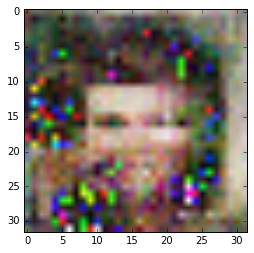

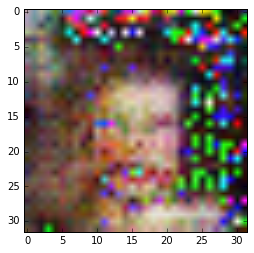

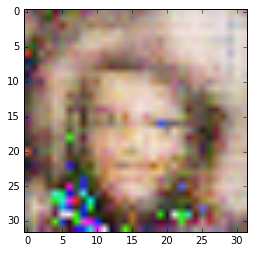

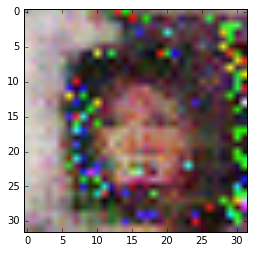

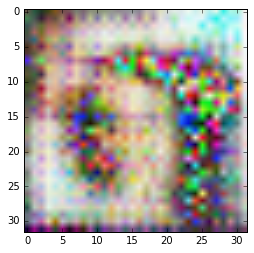

In [3]:
a = plt.imread("./output/8000_out.png")
plt.imshow(a)
plt.show()
a = plt.imread("./output/7000_out.png")
plt.imshow(a)
plt.show()
a = plt.imread("./output/1000_out.png")
plt.imshow(a)
plt.show()
a = plt.imread("./output/4000_out.png")
plt.imshow(a)
plt.show()
a = plt.imread("./output/6000_out.png")
plt.imshow(a)
plt.show()